In [1]:
import geopandas as gpd
import geojsonio as geoio
import pandas as pd
import numpy as np

from shapely.geometry import Point
from collections import Counter
import matplotlib.pyplot as plt
import seaborn

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Read Data 

In [2]:
vancouver_all_data = gpd.read_file('VancouverAllData.geojson')
vancouver_gdf = gpd.GeoDataFrame({'population':vancouver_all_data['pop'], 'geometry':vancouver_all_data['geometry']})
vancouver_gdf = vancouver_gdf.reset_index()

osm_data = pd.read_json('osm/amenities-vancouver.json.gz', lines=True, compression='gzip')


# Data Cleaning

In [3]:
# Cleaning: convert population to numeric
vancouver_gdf['population'] = pd.to_numeric(vancouver_gdf['population'])

# Cleaning: Form a coordinate point using lon and lat
osm_data['geometry'] = list(zip(osm_data['lon'],osm_data['lat']))
osm_data['geometry'] = osm_data['geometry'].apply(Point)
# Cleaning: Set the amenity name of all skytrain station
osm_data.loc[(osm_data['name'].str.contains('Station')) & (osm_data['amenity'] == 'bus_station'), 'amenity'] = 'skytrain_station'
# Cleaning: While creating gdf, lower case all amenities names
osm_gdf = gpd.GeoDataFrame({'amenity':osm_data['amenity'].apply(lambda x: x.lower()), 'geometry':osm_data['geometry']}, geometry='geometry', crs=vancouver_gdf.crs)

# Data Prep

In [4]:
# Calculate population density based on the give population and relative area in squared km
vancouver_gdf['area'] = vancouver_gdf['geometry'].to_crs({'init': 'epsg:3857'}).area / 10**6
vancouver_gdf['population_density'] = vancouver_gdf['population'] / (vancouver_gdf['area'])
# use spatial join to match points (osm data) and multipolygons (vancouver data)
pointInPolys = gpd.tools.sjoin(osm_gdf, vancouver_gdf, op="within", how='left')
# index_right is the index of the joined multipolygon, i.e. ID of an area
# group by area and for each area, get the list of amenities located in this area
amenitiesInEachArea = pointInPolys.groupby(['index_right'])['amenity'].apply(list)
# count the number of each amenity in the area and put it into dict
amenitiesInEachArea = amenitiesInEachArea.apply(lambda x: Counter(x))
vancouver_gdf['amenities'] = amenitiesInEachArea
# split the dict column into separate columns
vancouver_gdf = pd.concat([vancouver_gdf.drop(['amenities'], axis=1), vancouver_gdf['amenities'].apply(pd.Series)], axis=1)
# fill all NaN values with 0 and drop redundant columns
vancouver_gdf = vancouver_gdf.drop([0, 'index'], axis=1).fillna(0)
vancouver_gdf

/Users/raufshimarov/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/raufshimarov/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3301: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


,population,geometry,area,population_density,shelter,post_box,bank,fast_food,restaurant,bench,...,hunting_stand,waste_transfer_station,vacuum_cleaner,lounge,evse,storage_rental,atm;bank,healthcare,stripclub,money_transfer
0,6154,"MULTIPOLYGON (((-123.02353 49.20818, -123.0235...",2.387042,2578.086063,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,8245,"MULTIPOLYGON (((-123.02353 49.20818, -123.0234...",4.353334,1893.950524,1.0,1.0,5.0,3.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,6949,"MULTIPOLYGON (((-123.04245 49.20549, -123.0426...",4.542618,1529.734609,0.0,1.0,0.0,0.0,1.0,13.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3908,"MULTIPOLYGON (((-123.05918 49.21162, -123.0597...",1.838855,2125.235151,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4527,"MULTIPOLYGON (((-123.05918 49.21162, -123.0587...",1.805559,2507.257141,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
484,3530,"MULTIPOLYGON (((-122.57911 49.17246, -122.5788...",12.245989,288.257647,1.0,0.0,0.0,1.0,12.0,18.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
485,96,"MULTIPOLYGON (((-122.56953 49.17974, -122.5694...",4.088051,23.483075,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
486,6228,"MULTIPOLYGON (((-122.46134 49.16769, -122.4613...",139.389647,44.680506,0.0,1.0,0.0,3.0,2.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
487,4255,"MULTIPOLYGON (((-122.45998 49.07500, -122.4598...",7.147546,595.309206,0.0,0.0,0.0,2.0,3.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Data Processing

1893.2523572934374

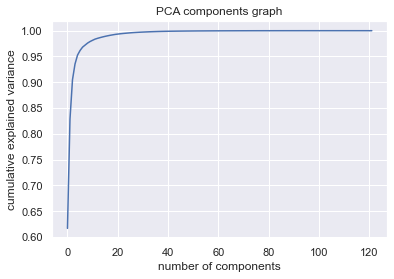

In [5]:
X = vancouver_gdf.drop(['population', 'geometry', 'area', 'population_density'], axis=1).values
y = vancouver_gdf['population_density'].values
X_train, X_valid, y_train, y_valid = train_test_split(X, y)

# plot pca results with different number of components
seaborn.set()
pca = PCA().fit(X_train.data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title('PCA components graph')

# train model
model = make_pipeline(
        StandardScaler(),
        PCA(40),
        PolynomialFeatures(degree=1, include_bias=True),
        LinearRegression(fit_intercept=False)
)

model.fit(X_train, y_train)
# validate model
predicted_y = model.predict(X_valid)

# calculate root mean squared error
rms = mean_squared_error(y_valid, predicted_y, squared=False)
rms

Text(0.5, 1.0, 'Calculated vs Predicted Population Density')

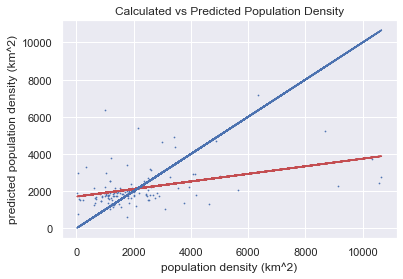

In [6]:
# # filter out negative scores for the predicted labels 
data = pd.DataFrame({'y_valid': y_valid, 'predicted_y': predicted_y})
data = data[data['predicted_y'] > 0]
y_valid = data['y_valid']
predicted_y = data['predicted_y']

# stack y to match shape of predicted y
y_valid_stack = np.stack([y_valid], axis=1)

linReg = LinearRegression(fit_intercept=True)
linReg.fit(y_valid_stack, predicted_y)
best_fit = linReg.intercept_ + linReg.coef_[0] * y_valid_stack

seaborn.set()
plt.scatter(y_valid_stack, predicted_y, s=0.5)
plt.plot(y_valid_stack, best_fit, '-r')
plt.plot(y_valid, y_valid, 'b-')
plt.xlabel('population density (km^2)')
plt.ylabel('predicted population density (km^2)')
plt.title('Calculated vs Predicted Population Density')

Text(0.5, 1.0, 'Population Density Residuals Histogram')

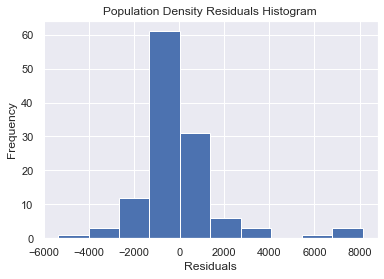

In [7]:
# make residuals plot
residuals = y_valid - predicted_y
seaborn.set()
plt.hist(residuals)

plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Population Density Residuals Histogram')

# Heatmap

In [8]:
predicted_y = model.predict(vancouver_gdf.drop(['population', 'geometry', 'area', 'population_density'], axis=1).values)

# Used predicted y-label and the original y-label to compute the percentage difference and produce the heatmap based on it
vancouver_gdf['predicted_population_density_difference'] = vancouver_gdf["population_density"] - predicted_y
vancouver_gdf['percentage_difference'] = (vancouver_gdf['predicted_population_density_difference'] / vancouver_gdf['population_density']) * 100

def getColorFromPercentage(percentage):
    if percentage < -80: 
        return '#8b7efd' # most blue
    elif percentage < -60:
        return '#a89bff'
    elif percentage < -40:
        return '#c3b9ff'
    elif percentage < -20:
        return '#ddd7ff'
    elif percentage < 0:
        return '#e4d4fe' # neutral light blue color
    elif percentage > 80:
        return '#ff3d61' # most red
    elif percentage > 60:
        return '#ff73a6'
    elif percentage > 40:
        return '#ffa4da'
    elif percentage > 20:
        return '#f4cff8'
    elif percentage >= 0:
        return '#ecd2fc' # neutral light red color

vancouver_gdf["amenity_count"] = vancouver_gdf.drop(['population', 'geometry', 'area', 'population_density', 'predicted_population_density_difference',	'percentage_difference'], axis=1).sum(axis=1)
# add fill attribute for geojson data
vancouver_gdf['fill'] = vancouver_gdf['percentage_difference'].apply(lambda percentage: getColorFromPercentage(percentage))
heatmap_gdf = gpd.GeoDataFrame({'geometry':vancouver_gdf['geometry'], 'fill':vancouver_gdf['fill'], 'pop_dens': vancouver_gdf['population_density'], 'amenity_count': vancouver_gdf['amenity_count']})
# convert the geopandas dataframe to a geojson file
heatmap_gdf.to_file('heatmap.geojson', driver="GeoJSON")
contents = gpd.read_file('heatmap.geojson')
# run server in browser to see geojson data over vancouver map
geoio.display(contents)


/Users/raufshimarov/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


'http://geojson.io/#id=gist:/1e0473b3ec3788131edd9dfc82c34af9'

# Statistical Analysis

In [9]:
red_areas = vancouver_gdf[vancouver_gdf['percentage_difference'] > 0]
blue_areas = vancouver_gdf[vancouver_gdf['percentage_difference'] <= 0]

In [10]:
# Now we find what amenities are important in red areas and in blue areas
red_areas_amenities = red_areas.drop(['population', 'geometry', 'area', 'population_density', 'predicted_population_density_difference',	'percentage_difference', 'amenity_count'], axis=1)
red_areas_amenities_avg = red_areas_amenities.mean().sort_values(ascending=False)

blue_areas_amenities = blue_areas.drop(['population', 'geometry', 'area', 'population_density', 'predicted_population_density_difference',	'percentage_difference', 'amenity_count'], axis=1)
blue_areas_amenities_avg = blue_areas_amenities.mean().sort_values(ascending=False)

red_and_blue_avg = pd.concat([red_areas_amenities_avg, blue_areas_amenities_avg], axis=1).rename({0: 'red_avg', 1:'blue_avg'}, axis=1)
red_and_blue_avg


/var/folders/dd/2sk2zf7j1wv0jkhkwl_3450h0000gn/T/ipykernel_4535/877820993.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  red_areas_amenities_avg = red_areas_amenities.mean().sort_values(ascending=False)
/var/folders/dd/2sk2zf7j1wv0jkhkwl_3450h0000gn/T/ipykernel_4535/877820993.py:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  blue_areas_amenities_avg = blue_areas_amenities.mean().sort_values(ascending=False)


,red_avg,blue_avg
bench,6.868421,6.003344
restaurant,4.621053,4.541806
bicycle_parking,2.926316,2.652174
cafe,2.000000,1.956522
fast_food,1.989474,1.946488
...,...,...
observation platform,0.000000,0.003344
lobby,0.000000,0.003344
smoking_area,0.000000,0.003344
letter_box,0.000000,0.003344


In [11]:
red_and_blue_avg = red_and_blue_avg.dropna()

from scipy import stats
print('Normality test: ', stats.normaltest(red_and_blue_avg['red_avg']).pvalue)
print('Levene\'s test: ', stats.levene(red_and_blue_avg['red_avg'], red_and_blue_avg['blue_avg']).pvalue)

ttest = stats.ttest_ind(red_and_blue_avg['red_avg'], red_and_blue_avg['blue_avg'])
print('T-test p-value:', ttest.pvalue)
print('Mann-Wittney p-value: ', stats.mannwhitneyu(red_and_blue_avg['red_avg'], red_and_blue_avg['blue_avg']).pvalue)


Normality test:  5.277062623645676e-39
Levene's test:  0.8956662510725832
T-test p-value: 0.885412462667327
Mann-Wittney p-value:  0.42358096858649963


In [12]:
red_areas['amenity_count'].corr(red_areas['population_density'])

0.37228054227917495

Note: nan means values do not vary as per https://stackoverflow.com/questions/22655667/dataframe-correlation-produces-nan-although-its-values-are-all-integers answered by Karl D.

In [13]:
red_areas_amenities_ = red_areas_amenities.drop(['fill'], axis=1)
correlations = {}
for col in red_areas_amenities_:
    correlations[col] = red_areas_amenities_[col].corr(red_areas['population_density'])
correlations = dict(sorted(correlations.items(), key=lambda item: abs(item[1]), reverse=True))
correlations

{'motorcycle_rental': nan,
 'car_sharing': 0.6322904718362524,
 'bicycle_rental': 0.5869336256951303,
 'restaurant': 0.40724494235129755,
 'bicycle_parking': 0.39566308272983997,
 'cafe': 0.3644310144585354,
 'pub': 0.3204961254042173,
 'post_box': 0.3136773233186069,
 'bar': 0.30956143537469294,
 'cinema': 0.28280873766795395,
 'bench': 0.2822974831718935,
 'fuel': -0.2447117722888574,
 'post_office': 0.23882153251805494,
 'car_rental': 0.2268130179519676,
 'fast_food': 0.2140237992475849,
 'pharmacy': 0.21353294010420326,
 'community_centre': 0.20162205344152723,
 'bank': 0.19546955829163457,
 'shelter': -0.1908768553674494,
 'fountain': 0.1750898871044197,
 'toilets': -0.17426816904352016,
 'waste_basket': 0.13890420220612834,
 'clinic': 0.12742546109603534,
 'public_bookcase': -0.12248932582449583,
 'dentist': 0.11830721024158074,
 'ice_cream': 0.11528486356141837,
 'shower': -0.111347274397496,
 'telephone': -0.10952794872044673,
 'veterinary': -0.10788195609758473,
 'place_of_wor

In [14]:
amenities_all = vancouver_gdf.drop(['population',	'geometry',	'area',	'population_density', 'fill', 'predicted_population_density_difference', 'percentage_difference', 'amenity_count'], axis=1)
correlations_all = {}
for col in amenities_all:
    correlations_all[col] = amenities_all[col].corr(vancouver_gdf['population_density'])
correlations_all = dict(sorted(correlations_all.items(), key=lambda item: abs(item[1]), reverse=True))
correlations_all

{'car_sharing': 0.4535124676405776,
 'bicycle_rental': 0.4004686505395074,
 'restaurant': 0.34184387359460366,
 'cafe': 0.3172170870454625,
 'nightclub': 0.3127157881587507,
 'payment_terminal': 0.2845443660505533,
 'bar': 0.26809016000533936,
 'post_box': 0.2653579372009865,
 'bicycle_parking': 0.26186661858579313,
 'pharmacy': 0.23615324530903997,
 'bank': 0.23463183977960034,
 'fast_food': 0.22302566479460378,
 'cinema': 0.22180765227709096,
 'pub': 0.21741316921748036,
 'dentist': 0.21483408107704102,
 'training': 0.19860607198062274,
 'community_centre': 0.19325761019121196,
 'post_office': 0.18411937550949542,
 'clinic': 0.18351412126249253,
 'bench': 0.17156243826672796,
 'internet_cafe': 0.1651145690159546,
 'ice_cream': 0.16138009426152847,
 'car_rental': 0.15422199634844105,
 'taxi': 0.14990529209562042,
 'parking_entrance': 0.1452696853222993,
 'shelter': -0.13211110968407244,
 'fuel': -0.12596584586010195,
 'toilets': -0.12565675127501053,
 'bureau_de_change': 0.12473882524

In [15]:
import json

with open('file.json', 'w') as file:
     file.write(json.dumps(correlations_all)) # use `json.loads` to do the reverse

In [16]:
import json
import math

with open("file.json") as f:
    data = f.read()
scores = json.loads(data)

for k,v in scores.items():
    if math.isnan(v):
        scores[k] = 0

scores_vector = []
for i in range(len(amenities_all.columns)):
    scores_vector.append(scores[amenities_all.columns[i]])
scores_vector

scaled_train = amenities_all * scores_vector * 100
scaled_train

,shelter,post_box,bank,fast_food,restaurant,bench,fuel,library,cafe,post_office,...,hunting_stand,waste_transfer_station,vacuum_cleaner,lounge,evse,storage_rental,atm;bank,healthcare,stripclub,money_transfer
0,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,...,-0.0,-0.0,-0.000000,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0
1,-13.211111,26.535794,117.315920,66.907699,68.368775,17.156244,-12.596585,-0.484487,63.443417,18.411938,...,-0.0,-0.0,-0.000000,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0
2,-0.000000,26.535794,0.000000,0.000000,34.184387,223.031170,-0.000000,-0.000000,0.000000,0.000000,...,-0.0,-0.0,-0.000000,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0
3,-0.000000,26.535794,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.484487,0.000000,0.000000,...,-0.0,-0.0,-0.000000,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0
4,-0.000000,53.071587,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,...,-0.0,-0.0,-0.000000,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
484,-13.211111,0.000000,0.000000,22.302566,410.212648,308.812389,-12.596585,-0.484487,222.051961,18.411938,...,-0.0,-0.0,-0.000000,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0
485,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,...,-0.0,-0.0,-0.000000,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0
486,-0.000000,26.535794,0.000000,66.907699,68.368775,85.781219,-12.596585,-0.000000,31.721709,0.000000,...,-0.0,-0.0,-0.000000,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0
487,-0.000000,0.000000,0.000000,44.605133,102.553162,17.156244,-0.000000,-0.000000,95.165126,0.000000,...,-0.0,-0.0,-0.000000,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0


In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

X = scaled_train.values
y = vancouver_gdf['population_density'].values
X_train, X_valid, y_train, y_valid = train_test_split(X, y)

# train model
model = make_pipeline(
        StandardScaler(),
        PCA(40),
        PolynomialFeatures(degree=1, include_bias=True),
        LinearRegression(fit_intercept=False)
)

model.fit(X_train, y_train)
# validate model
predicted_y = model.predict(X_valid)

# calculate root mean squared error
rms = mean_squared_error(y_valid, predicted_y, squared=False)
rms

1627.1376484872915

In [18]:
predicted_y = model.predict(amenities_all.values)

vancouver_gdf['predicted_population_density_difference'] = vancouver_gdf["population_density"] - predicted_y
vancouver_gdf['percentage_difference'] = (vancouver_gdf['predicted_population_density_difference'] / vancouver_gdf['population_density']) * 100

def getColorFromPercentage(percentage):
    if percentage < -80:
        return '#8b7efd'
    elif percentage < -60:
        return '#a89bff'
    elif percentage < -40:
        return '#c3b9ff'
    elif percentage < -20:
        return '#ddd7ff'
    elif percentage < 0:
        return '#e4d4fe'
    elif percentage > 80:
        return '#ff3d61'
    elif percentage > 60:
        return '#ff73a6'
    elif percentage > 40:
        return '#ffa4da'
    elif percentage > 20:
        return '#f4cff8'
    elif percentage >= 0:
        return '#ecd2fc'

vancouver_gdf["amenity_count"] = vancouver_gdf.drop(['population', 'geometry', 'area', 'population_density', 'predicted_population_density_difference',	'percentage_difference'], axis=1).sum(axis=1)
vancouver_gdf['fill'] = vancouver_gdf['percentage_difference'].apply(lambda percentage: getColorFromPercentage(percentage))
heatmap_gdf = gpd.GeoDataFrame({'geometry':vancouver_gdf['geometry'], 'fill':vancouver_gdf['fill'], 'pop_dens': vancouver_gdf['population_density'], 'amenity_count': vancouver_gdf['amenity_count']})
heatmap_gdf.to_file('heatmap-weighted.geojson', driver="GeoJSON")
contents = gpd.read_file('heatmap-weighted.geojson')
geoio.display(contents)


/var/folders/dd/2sk2zf7j1wv0jkhkwl_3450h0000gn/T/ipykernel_4535/3868350653.py:28: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  vancouver_gdf["amenity_count"] = vancouver_gdf.drop(['population', 'geometry', 'area', 'population_density', 'predicted_population_density_difference',	'percentage_difference'], axis=1).sum(axis=1)
/Users/raufshimarov/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


'http://geojson.io/#id=gist:/5256c4f3ee0faf666c9d55c1fc89b86b'